In [58]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Read csv

In [59]:
#read the csv
#column Breed shows the y with the image name
data_csv = pd.read_csv('dataset_CV.csv')
data_csv.head()

,DogId,Breed,Image,ImageNumber
0,6673,SIBERIAN HUSKY,4d924d95-de4c-43c0-a586-9fb19cadf905.jpg,1
1,6673,SIBERIAN HUSKY,851cc9ee-fc4d-430c-99f6-6425b8bbbe6b.jpg,2
2,6673,SIBERIAN HUSKY,7d055dfa-dc6f-4f2b-a7be-dc8bc666836f.jpg,3
3,6673,SIBERIAN HUSKY,f1f55f0a-c3d6-442b-b686-71b83b510dc5.jpg,4
4,6671,SIBERIAN HUSKY,a2e49a61-7c6a-46f0-a80e-9f32e596c1df.jpg,1


In [60]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144 entries, 0 to 4143
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DogId        4144 non-null   int64 
 1   Breed        4144 non-null   object
 2   Image        4144 non-null   object
 3   ImageNumber  4144 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 129.6+ KB


# Preprocessing

In [61]:
data_dir = r"image_classes"

### Create a dataset
Define some parameters for the loader:

In [62]:
batch_size = 32
img_height = 180
img_width = 180

In [63]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4144 files belonging to 5 classes.
Using 3316 files for training.


In [64]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4144 files belonging to 5 classes.
Using 828 files for validation.


In [65]:
class_names = train_ds.class_names
print(class_names)

['AMERICAN STAFFORDSHIRE BULL TERRIER', 'BORDER COLLIE', 'BULL ARAB', 'GERMAN SHEPHERD', 'SIBERIAN HUSKY']


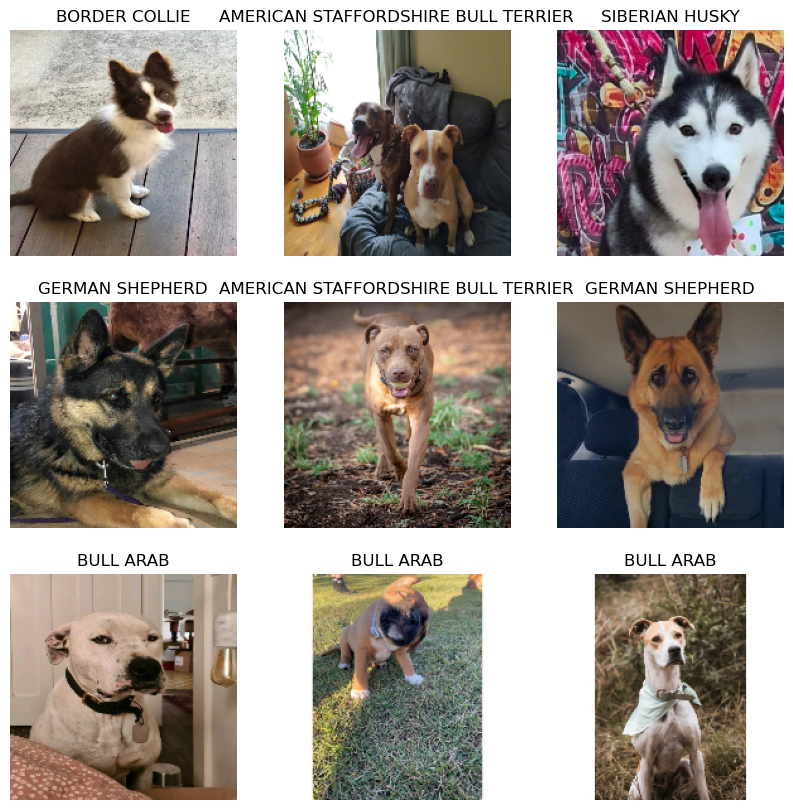

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [67]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [68]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [69]:
normalization_layer = layers.Rescaling(1. / 255)

In [70]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011510515 1.0


# Data Augmentation

In [71]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

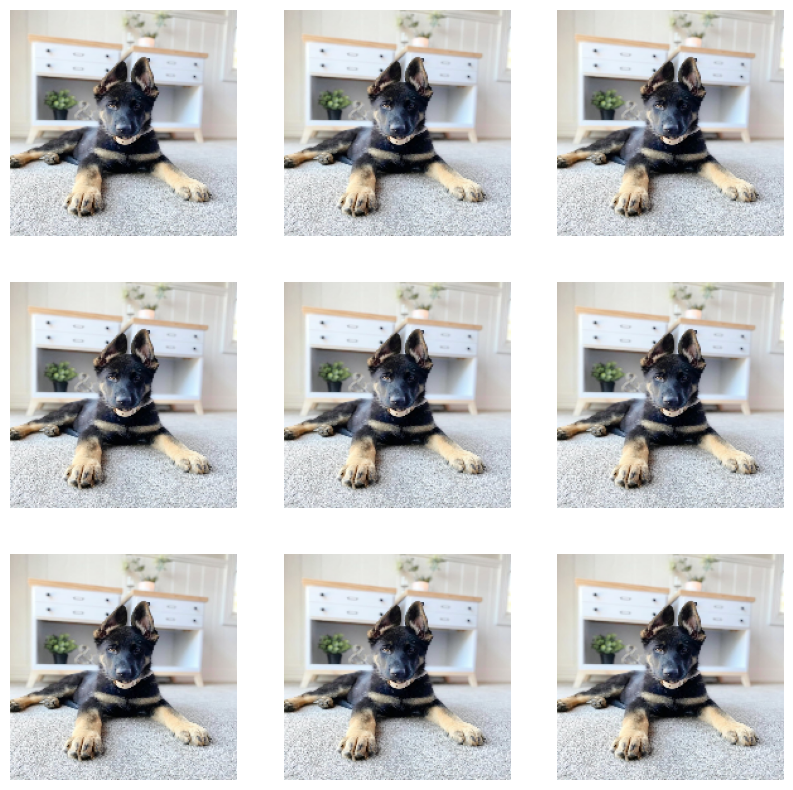

In [72]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Define cnn model

In [73]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# Training

In [75]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
104/104 [==============================] - 41s 371ms/step - loss: 1.6037 - accuracy: 0.2410 - val_loss: 1.5792 - val_accuracy: 0.3043
Epoch 2/15
104/104 [==============================] - 39s 375ms/step - loss: 1.4985 - accuracy: 0.3468 - val_loss: 1.5380 - val_accuracy: 0.3188
Epoch 3/15
104/104 [==============================] - 40s 384ms/step - loss: 1.4091 - accuracy: 0.4053 - val_loss: 1.3769 - val_accuracy: 0.4384
Epoch 4/15
104/104 [==============================] - 40s 384ms/step - loss: 1.3704 - accuracy: 0.4270 - val_loss: 1.4363 - val_accuracy: 0.4046
Epoch 5/15
104/104 [==============================] - 40s 380ms/step - loss: 1.3125 - accuracy: 0.4683 - val_loss: 1.4246 - val_accuracy: 0.4046
Epoch 6/15
104/104 [==============================] - 41s 390ms/step - loss: 1.2512 - accuracy: 0.4970 - val_loss: 1.4041 - val_accuracy: 0.4457
Epoch 7/15
104/104 [==============================] - 41s 392ms/step - loss: 1.2006 - accuracy: 0.5226 - val_loss: 1.3402 - val_ac

# Evaluating

# Plotting

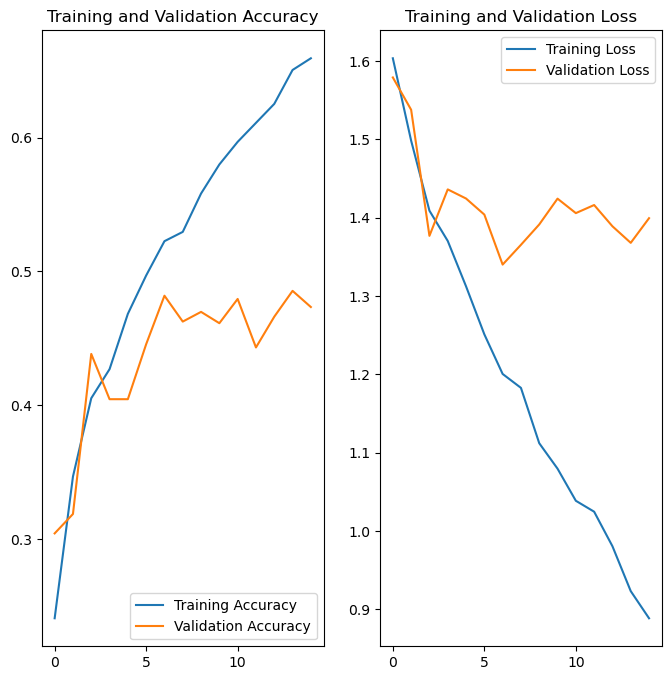

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()